### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

### Load Data

In [2]:
titanic_data = pd.read_csv('train.csv')
titanic_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<AxesSubplot:>

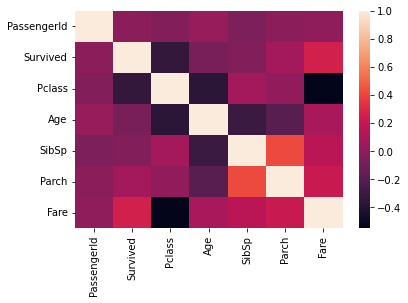

In [3]:
import seaborn as sns
sns.heatmap(titanic_data.corr())

### Remove unwanted values

In [4]:
titanic_data.head()
titanic_data.drop(columns=['Name', 'Ticket','PassengerId','Cabin'],inplace = True)

In [5]:
titanic_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [6]:
categorical_columns = titanic_data.select_dtypes(exclude=["float64","int64"]).columns
categorical_columns

Index(['Sex', 'Embarked'], dtype='object')

In [7]:
titanic_data.Sex = titanic_data['Sex'].apply(lambda x:1 if x == "male" else 0)

In [8]:
titanic_data.Embarked.unique()
titanic_data.Embarked = titanic_data.Embarked.apply(lambda x:3 if pd.isnull(x) else x)
titanic_data.Embarked = titanic_data.Embarked.apply(lambda x:0 if x=='S' else x)
titanic_data.Embarked = titanic_data.Embarked.apply(lambda x:1 if x=='C' else x)
titanic_data.Embarked = titanic_data.Embarked.apply(lambda x:2 if x == 'Q' else x)

In [9]:
titanic_data
mean_age = titanic_data.Age.mean()
titanic_data.Age = titanic_data.Age.apply(lambda x:mean_age if math.isnan(x) else x)

### Data Manipulation

(array([111.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  68.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

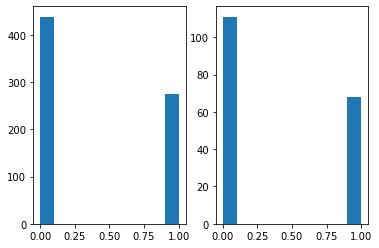

In [10]:
#Keep sex, Class and Survived ratio in equal number
from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits = 1,test_size = 0.2, random_state = 1234)
for train_indices,test_indices in split.split(titanic_data,titanic_data[['Survived','Pclass','Sex']]):
    strat_train_set = titanic_data.loc[train_indices]
    strat_test_set = titanic_data.loc[test_indices]
plt.subplot(1,2,1)
plt.hist(strat_train_set.Survived)
plt.subplot(1,2,2)
plt.hist(strat_test_set.Survived)

In [11]:
strat_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 147 to 575
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  712 non-null    int64  
 1   Pclass    712 non-null    int64  
 2   Sex       712 non-null    int64  
 3   Age       712 non-null    float64
 4   SibSp     712 non-null    int64  
 5   Parch     712 non-null    int64  
 6   Fare      712 non-null    float64
 7   Embarked  712 non-null    int64  
dtypes: float64(2), int64(6)
memory usage: 50.1 KB


### Scale Data

In [12]:
from sklearn.preprocessing import StandardScaler
X = strat_train_set.drop(['Survived'],axis = 1)
y = strat_train_set.Survived
scaler = StandardScaler()
X_data = scaler.fit_transform(X)
y_data = y.to_numpy()

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
clf = RandomForestClassifier()
param = [
    {"n_estimators":[10,100,200,500,1000],
    "max_depth":[None,5,10,15,20],
    "min_samples_split":[2,3,4,5,6,7,8]}
]

grid_search = GridSearchCV(clf,param,cv = 3,scoring= "accuracy",return_train_score = True)
grid_search.fit(X_data,y_data)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}],
             return_train_score=True, scoring='accuracy')

In [14]:
final_clf = grid_search.best_estimator_

In [15]:
final_clf

RandomForestClassifier(max_depth=10, min_samples_split=4)

In [16]:
X = strat_test_set.drop(['Survived'],axis = 1)
y = strat_test_set.Survived
scaler = StandardScaler()
X_test = scaler.fit_transform(X)
y_test = y.to_numpy()

In [17]:
final_clf.score(X_test,y_test)

0.7877094972067039

In [18]:
X = titanic_data.drop(['Survived'],axis = 1)
y = titanic_data.Survived
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = y.to_numpy()
grid_search = GridSearchCV(clf,param,cv = 3,scoring= "accuracy",return_train_score = True)
grid_search.fit(X,y)
final_clf = grid_search.best_estimator_

In [32]:
X

array([[ 0.82737724,  0.73769513, -0.5924806 , ..., -0.47367361,
        -0.50244517, -0.56876427],
       [-1.56610693, -1.35557354,  0.63878901, ..., -0.47367361,
         0.78684529,  0.97626307],
       [ 0.82737724, -1.35557354, -0.2846632 , ..., -0.47367361,
        -0.48885426, -0.56876427],
       ...,
       [ 0.82737724, -1.35557354,  0.        , ...,  2.00893337,
        -0.17626324, -0.56876427],
       [-1.56610693,  0.73769513, -0.2846632 , ..., -0.47367361,
        -0.04438104,  0.97626307],
       [ 0.82737724,  0.73769513,  0.17706291, ..., -0.47367361,
        -0.49237783,  2.52129041]])

In [19]:
final_clf.score(X,y)

0.9270482603815937

### Apply Machine Learning on real test data

In [20]:
test_data = pd.read_csv('test.csv')
test_data.drop(columns=['Name', 'Ticket','PassengerId','Cabin'],inplace = True)

In [21]:
test_data.Sex = test_data['Sex'].apply(lambda x:1 if x == "male" else 0)

In [22]:
test_data.Embarked.unique()
test_data.Embarked = test_data.Embarked.apply(lambda x:3 if pd.isnull(x) else x)
test_data.Embarked = test_data.Embarked.apply(lambda x:0 if x=='S' else x)
test_data.Embarked = test_data.Embarked.apply(lambda x:1 if x=='C' else x)
test_data.Embarked = test_data.Embarked.apply(lambda x:2 if x == 'Q' else x)

In [23]:
test_data.Age = test_data.Age.apply(lambda x:mean_age if math.isnan(x) else x)

In [24]:
test_data.Fare = test_data.Fare.apply(lambda x:test_data.Fare.mean() if math.isnan(x) else x)

In [34]:
test_data = scaler.fit_transform(test_data)
test_data

array([[ 0.87348191,  0.75592895,  0.34428417, ..., -0.4002477 ,
        -0.49840706,  2.24316522],
       [ 0.87348191, -1.32287566,  1.33465451, ..., -0.4002477 ,
        -0.51327429, -0.6778412 ],
       [-0.31581919,  0.75592895,  2.52309891, ..., -0.4002477 ,
        -0.46508846,  2.24316522],
       ...,
       [ 0.87348191,  0.75592895,  0.66120268, ..., -0.4002477 ,
        -0.50879189, -0.6778412 ],
       [ 0.87348191,  0.75592895, -0.03608795, ..., -0.4002477 ,
        -0.4944482 , -0.6778412 ],
       [ 0.87348191,  0.75592895, -0.03608795, ...,  0.61989583,
        -0.23790598,  0.78266201]])

In [35]:
predictions = final_clf.predict(test_data)

In [26]:
test = pd.read_csv('test.csv')

In [36]:
final_df = pd.DataFrame(test['PassengerId'])
final_df['Survived'] = predictions
final_df.to_csv('predictions.csv',index = False)

In [30]:
titanic_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,1,22.000000,1,0,7.2500,0
1,1,1,0,38.000000,1,0,71.2833,1
2,1,3,0,26.000000,0,0,7.9250,0
3,1,1,0,35.000000,1,0,53.1000,0
4,0,3,1,35.000000,0,0,8.0500,0
...,...,...,...,...,...,...,...,...
886,0,2,1,27.000000,0,0,13.0000,0
887,1,1,0,19.000000,0,0,30.0000,0
888,0,3,0,29.699118,1,2,23.4500,0
889,1,1,1,26.000000,0,0,30.0000,1


In [31]:
test_data

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,34.500000,0,0,7.8292,2
1,3,0,47.000000,1,0,7.0000,0
2,2,1,62.000000,0,0,9.6875,2
3,3,1,27.000000,0,0,8.6625,0
4,3,0,22.000000,1,1,12.2875,0
...,...,...,...,...,...,...,...
413,3,1,29.699118,0,0,8.0500,0
414,1,0,39.000000,0,0,108.9000,1
415,3,1,38.500000,0,0,7.2500,0
416,3,1,29.699118,0,0,8.0500,0
